In [1]:
%matplotlib inline
from skimage import graph, data, io, segmentation, color
from matplotlib import pyplot as plt
from skimage.measure import regionprops
from skimage import draw
import numpy as np
import json
import base64
import matplotlib.image as mpimg
from skimage import color
from matplotlib import pyplot as plt

In [2]:
def show_img(img):
 
    width = img.shape[1]/75.0
    height = img.shape[0]*width/img.shape[1]
    f = plt.figure(figsize=(width, height))
    plt.imshow(img, cmap='gray')

(240, 320)


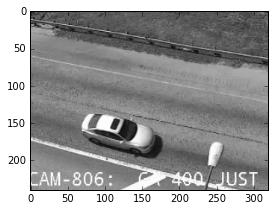

In [3]:
import io
jf = json.loads(open('cams/cam806/frames/cam806_1.json').read())
image1 = color.rgb2gray(mpimg.imread(io.BytesIO(base64.b64decode(jf['frame'])),format='png'))
print image1.shape
show_img(image1)

In [4]:
from skimage import graph, data, io, segmentation, color
def loadframes(frames):
    for f in frames:
        img = color.rgb2gray(io.imread(f))
        yield img.flat

In [5]:
import glob   
path = 'cams/cam806/frames/*.png'   
frames=glob.glob(path)

In [6]:
F = np.column_stack(loadframes(frames))
F_med = np.median(F, axis=1)
F_med_img = F_med.reshape(240,320)

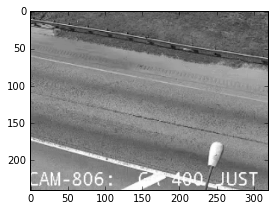

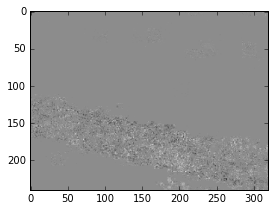

In [42]:
seq=16
frame=F[:,seq]
show_img(frame.reshape(240,320))
show_img(np.subtract(frame,F_med).reshape(240,320))

In [43]:
from scipy.linalg import svd as svd_

def _pos(A):
    return A * (A > 0)


def _fro(A):
    return np.sqrt((A * A).sum())

def svd(X, k=-1):
    U, S, V = svd_(X, full_matrices=False)
    if k < 0:
        return U, S, V
    else:
        return U[:, :k], S[:k], V[:k, :]
        
#Alternating Direction Method of Multipliers
def ADMM(D, lmbda, rho=1., maxiter=25000, verbose=2, tol=1e-2):

    def soft_thresh(X, sigma):
        return np.maximum(X - sigma, 0) - np.maximum(-X - sigma, 0);

    obj = []
    m, n = D.shape
    A = D;
    E = D - A;
    W = np.ones(D.shape)/rho;
    rhoupdate = rho;

    for k in range(maxiter):
        U, S, V = svd(D-E-W);
        Aupdate = np.dot(np.dot(U, np.diag(soft_thresh(S, 1/rho))), V);
        Eupdate = soft_thresh(D-Aupdate-W, lmbda/rho);
        Wupdate = W + (Aupdate + Eupdate - D);
        primal_resid = _fro(Aupdate + Eupdate - D)
        dual_resid = rho*_fro(Eupdate - E)

        # this is from the stanford slide
        if primal_resid > 10*dual_resid:
            rhoupdate = 2*rho;
            Wupdate = Wupdate/2;
        elif dual_resid > 10*primal_resid:
            rhoupdate = rho/2;
            Wupdate = 2*Wupdate;
        else:
            rhoupdate = rho

        A = Aupdate;
        E = Eupdate;
        W = Wupdate;
        rho = rhoupdate;

        if primal_resid <= tol and dual_resid <= tol:
            if verbose >= 2:
                print 'Converged to tol=%e in %d iterations\n'%(tol, k)
            break;
        if verbose >= 2:
            obj.append(_monitor(A, E, D))

    if verbose >= 2:
        return A, E, obj
    else:
        return A, E

In [44]:
A, E = ADMM(F, lmbda=.01, maxiter=100, verbose=0)
A = A.reshape(240, 320, F.shape[1]) * 255.
E = E.reshape(240, 320, F.shape[1]) * 255.
A.shape
E.shape

(240, 320, 30)

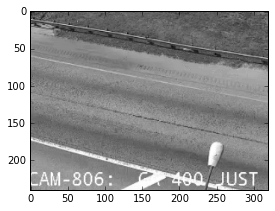

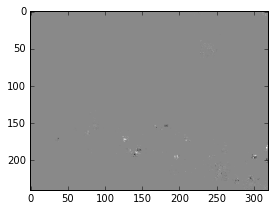

In [45]:
show_img(A[:,:,seq])
show_img(E[:,:,seq])

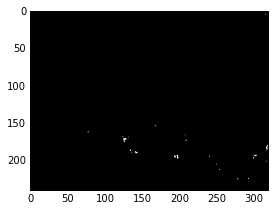

In [46]:
from skimage.filters.thresholding import threshold_otsu
thresh = threshold_otsu(E[:,:,seq])
E_thresh = E[:,:,seq] > thresh
show_img(E_thresh)

In [47]:
thresh

2.4126180024637893

In [48]:
result=E_thresh

In [49]:
# Find the largest connect component
from scipy import ndimage
label_im, nb_labels = ndimage.label(result)
sizes = ndimage.sum(result, label_im, range(nb_labels + 1))
# Remove small objects
mask_size = sizes < 100
remove_pixel = mask_size[label_im]
label_im[remove_pixel] = 0

labels = np.unique(label_im)
label_im = np.searchsorted(labels, label_im)

In [50]:
# Now that we have only one connect component, extract it's bounding box
dx, dy = ndimage.find_objects(label_im==1)[0]
roi = result[dx, dy]

IndexError: list index out of range

In [51]:
sizes

array([ 0.,  1.,  2.,  2.,  1.,  1.,  1.,  8.,  2.,  3.,  6.,  6.,  2.,
        2.,  1.,  7.,  1.,  7.,  1.,  6.,  5.,  1.,  2.,  1.,  1.,  1.,
        1.,  1.,  1.])

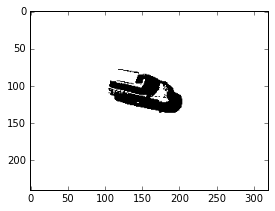

In [37]:
show_img(roi) 

In [38]:
class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        '''
        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.
        '''
        if x1 > x2: x1, x2 = x2, x1
        if y1 > y2: y1, y2 = y2, y1
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    def taxicab_diagonal(self):
        '''
        Return the taxicab distance from (x1,y1) to (x2,y2)
        '''
        return self.x2 - self.x1 + self.y2 - self.y1
    def overlaps(self, other):
        '''
        Return True iff self and other overlap.
        '''
        return not ((self.x1 > other.x2)
                    or (self.x2 < other.x1)
                    or (self.y1 > other.y2)
                    or (self.y2 < other.y1))
    def __eq__(self, other):
        return (self.x1 == other.x1
                and self.y1 == other.y1
                and self.x2 == other.x2
                and self.y2 == other.y2)

In [39]:
img = frame.reshape(240,320)

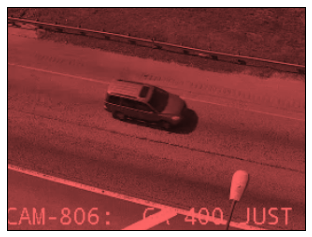

In [40]:
from skimage import data, color, io, img_as_float
bbox = BBox(dx.start, dy.start, dx.stop+1, dy.stop+1)
xwidth = bbox.x2 - bbox.x1
ywidth = bbox.y2 - bbox.y1

alpha = 0.6
rows, cols = img.shape

# Construct a colour image to superimpose
color_mask = np.zeros((rows, cols, 3))
color_mask[bbox.x1:bbox.x2, bbox.y1:bbox.y2] = [1, 0, 0]  # Red block

# Construct RGB version of grey-level image
img_color = np.dstack((img, img, img))

# Convert the input image and color mask to Hue Saturation Value (HSV)
# colorspace
img_hsv = color.rgb2hsv(img_color)
color_mask_hsv = color.rgb2hsv(color_mask)

# Replace the hue and saturation of the original image
# with that of the color mask
img_hsv[..., 0] = color_mask_hsv[..., 0]
img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

img_masked = color.hsv2rgb(img_hsv)

# Display the output
f, ax1 = plt.subplots(1, 1, subplot_kw={'xticks': [], 'yticks': []})
ax1.imshow(img_masked)